In [1]:
%load_ext autoreload

# Gaussian Mixture Model

In [2]:
%matplotlib inline
import os, sys
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath(os.path.join('..')))

import plot.anomalies
from plot import pyplot as plt
from database.CERNMongoClient import CERNMongoClient
from anomaly_detection import GMM
from feature_extraction import feature_extraction, preprocessing, PCA

db = CERNMongoClient()

# auto-load changes in imported modules
%autoreload 2

In [3]:
df = db.query("^MKI.(A|B).*B1:.*", resample_to='1min')

Fetching data for pattern ^MKI.(A|B).*B1:.* from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.A5L2.B1:TEMP_MAGNET_UP
Fetching data for MKI.B5L2.B1:PRESSURE
Fetching data for MKI.B5L2.B1:TEMP_TUBE_DOWN
Fetching data for MKI.A5L2.B1:TEMP_TUBE_DOWN
Fetching data for MKI.B5L2.B1:TEMP_MAGNET_DOWN
Fetching data for MKI.B5L2.B1:TEMP_TUBE_UP
Fetching data for MKI.A5L2.B1:TEMP_TUBE_UP
Fetching data for MKI.B5L2.B1:TEMP_MAGNET_UP
Fetching data for MKI.A5L2.B1:PRESSURE
Fetching data for MKI.A5L2.B1:TEMP_MAGNET_DOWN


In [4]:
display("Original data size: %s" % df.shape[0])
df_f = preprocessing.filter_extremes(df)
display("Filered data size: %s" % df_f.shape[0])

'Original data size: 216000'

'Filered data size: 216000'

Above code filters away pressure outside of [9x10^-12,  5x10^-9] mbar, magnet temperature outside of [18, 60] degrees Celcius and tube temperature outside of [18, 120] degrees Celcius. The resulting data will be used to fit the model. The original data will be used to detect anomalies.

In [5]:
data_filtered = preprocessing.scale(df_f)
data_unfiltered = preprocessing.scale(df)

In [6]:
clf = GMM.GMM(n_components=7, covariance_type='full')
clf.fit(data_filtered)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=7, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [7]:
log_probs = clf.anomaly_scores(data_unfiltered)
display("Log probs mean: %s" % log_probs.mean())
display("Log probs min: %s" % log_probs.min())
display("Log probs max: %s" % log_probs.max())

'Log probs mean: -0.4069634703322943'

'Log probs min: -116203.76381127052'

'Log probs max: 9.961030070864556'

1 point so extreme that it heavily influences outcome.

'Log probs mean: 10.897910264302942'

'Log probs min: -1851.594205289254'

'Log probs max: 26.636100740577493'

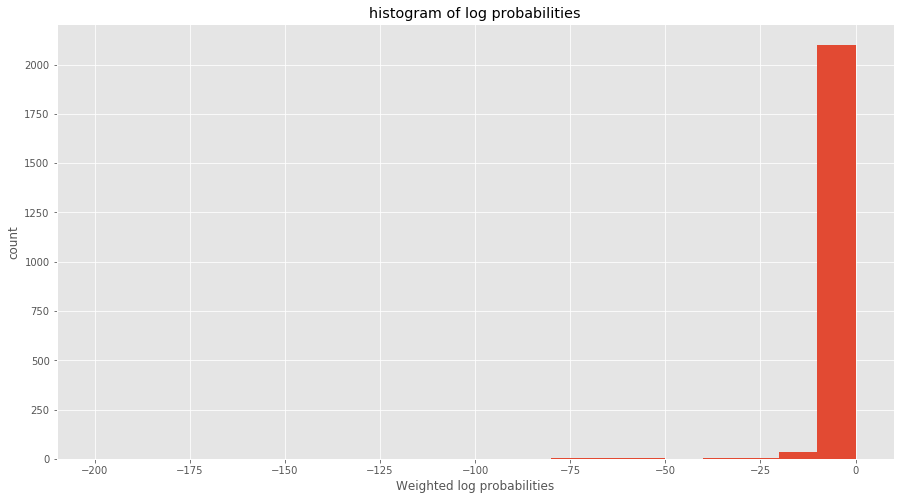

In [8]:
log_probs = clf.anomaly_scores(data_filtered)
display("Log probs mean: %s" % log_probs.mean())
display("Log probs min: %s" % log_probs.min())
display("Log probs max: %s" % log_probs.max())
pct = np.percentile(log_probs, 1)
idx = np.where((log_probs < pct))
anomaly_log_probs = log_probs[idx]
binwidth = 10
plt.figure()
plt.hist(anomaly_log_probs, bins=np.arange(-200, max(anomaly_log_probs) + binwidth, binwidth));
plt.title("histogram of log probabilities")
plt.xlabel('Weighted log probabilities')
plt.ylabel('count')

Above plot shows the histogram of the 1 percent most anomalous datapoints above -200 (removed for clarity, plot would be very stretched over x axis). This gives an indication for the threshold.

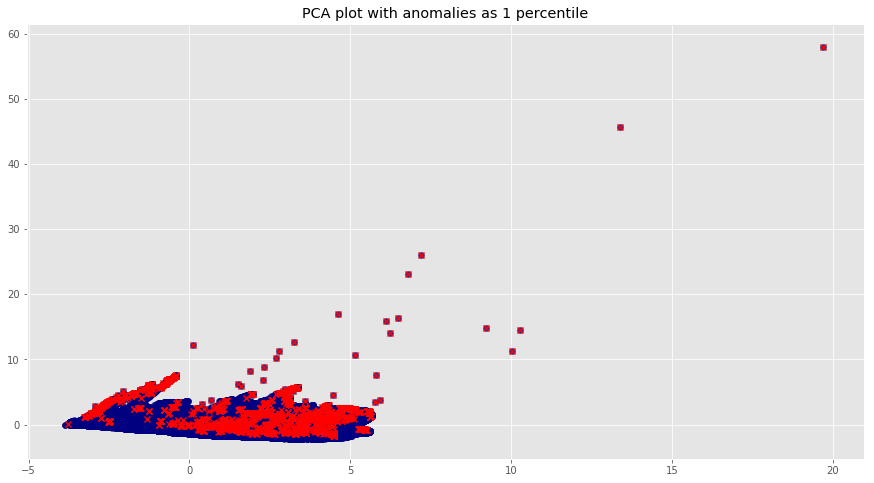

In [9]:
p = PCA.PCA(n_components=2)
pca_data = p.transform(data_filtered)
p.plot_anomalies(pca_data, idx[0], "PCA plot with anomalies as 1 percentile")

Remarks:
- bottom "band" was detected as anomaly in previous notebook, not anymore by training on all the data instead of 50/50 split

In [10]:
log_probs_df = pd.DataFrame(data=log_probs, index=df_f.index)
anomaly_log_probs_df = log_probs_df.iloc[idx[0].tolist()]

min30 = feature_extraction.sliding_window_mean(log_probs_df, "min", 30)

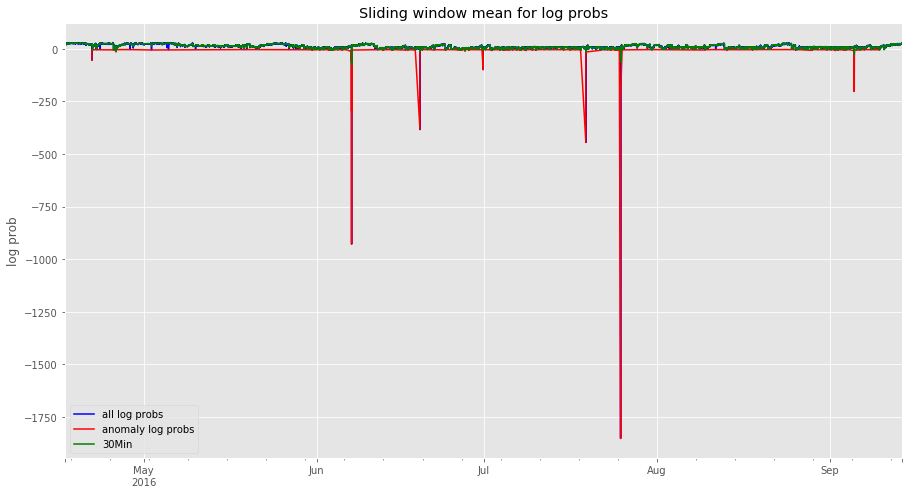

In [11]:
fig, axes = plt.subplots()

log_probs_df.plot(ax=axes, color='b')
anomaly_log_probs_df.plot(ax=axes, color='r')
min30.plot(ax=axes,color='g')

axes.legend(["all log probs", "anomaly log probs", "30Min"])
axes.set_ylabel("log prob")
axes.set_title("Sliding window mean for log probs")

The blue line are all the log probabilities from the GMM. Red is the 1 pct which could be anomalies. Green is a sliding window of 30 min over blue. These are already logarithmic, but still 3 very low points which make the plot unclear.

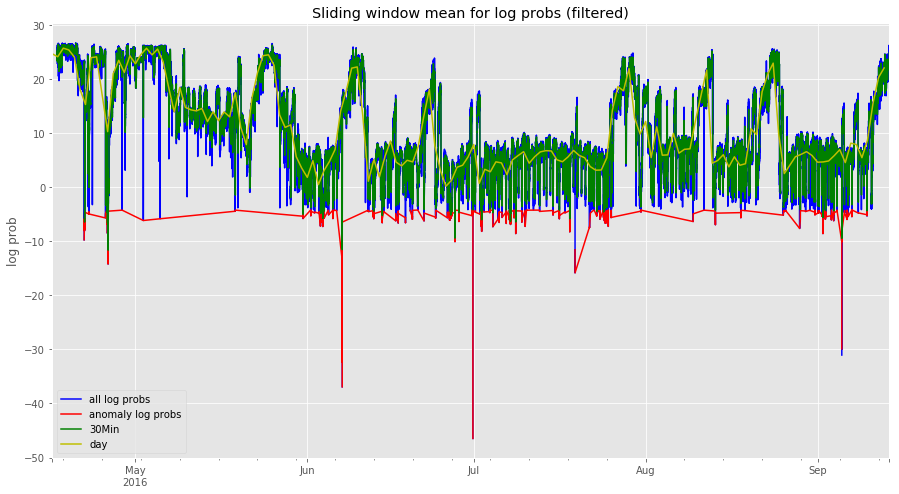

In [12]:
log_probs_df2 = log_probs_df[log_probs_df>-50]
anomaly_log_probs_df2 = anomaly_log_probs_df[anomaly_log_probs_df>-50]
min30 = feature_extraction.sliding_window_mean(log_probs_df2, 'T', 30)
day = feature_extraction.sliding_window_mean(log_probs_df2, 'D', 1)

fig, axes = plt.subplots()

log_probs_df2.plot(ax=axes, color='b')
anomaly_log_probs_df2.plot(ax=axes, color='r')
min30.plot(ax=axes, color='g')
day.plot(ax=axes, color='y')

axes.legend(["all log probs", "anomaly log probs", "30Min", "day"])
axes.set_ylabel("log prob")
axes.set_title("Sliding window mean for log probs (filtered)")

Figure 4 is identical to figure 3, but only with log probabilities above 50. This threshold was decided by figure 1. A possible way to detect anomalies would be to take the difference between the measured anomaly and its dayly slided window.

In [13]:
idx2 = np.argpartition(log_probs, 20) #first 20 elements will be the indexes of smallest elements
idx2 = idx2[:21]
# gives only 4 days with anomalies

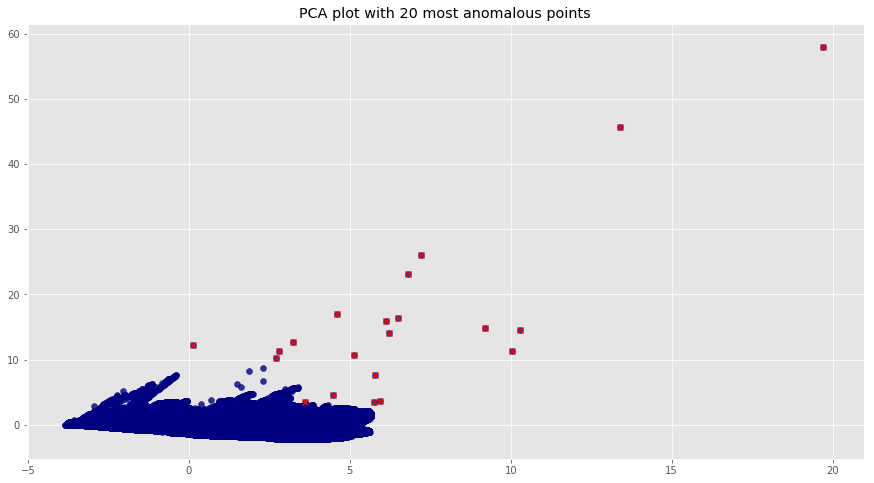

In [14]:
p.plot_anomalies(pca_data, idx2, "PCA plot with 20 most anomalous points")

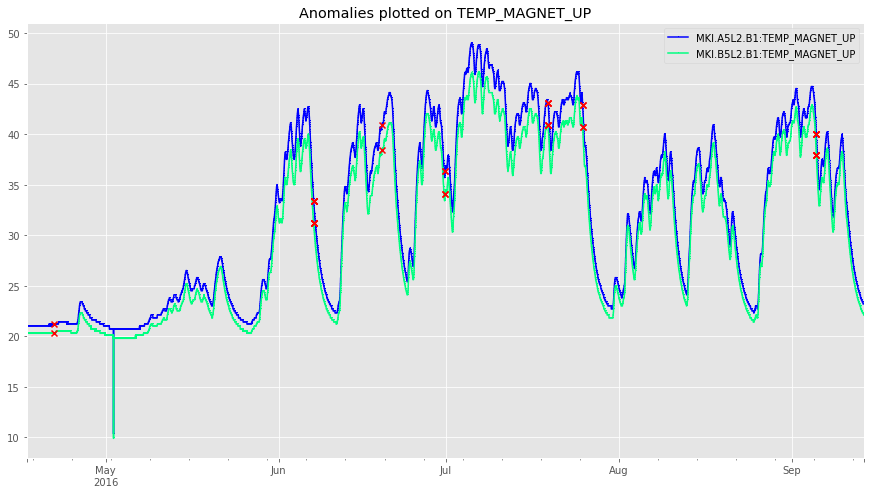

In [15]:
plot.anomalies.anomalies_timeseries(df, "TEMP_MAGNET_UP", idx2, "Anomalies plotted on TEMP_MAGNET_UP")

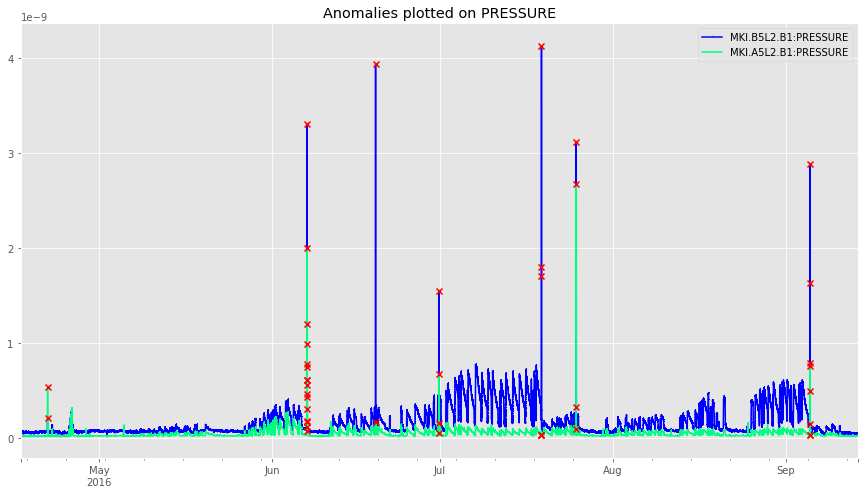

In [16]:
plot.anomalies.anomalies_timeseries(df_f, "PRESSURE", idx2, "Anomalies plotted on PRESSURE")
# passing filtered df else, 1 big spike and flatline
# indexes are technically off by 1 now